In [1]:
import keras
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical, plot_model
from keras.models import Model
from keras.layers import (Input, Dense, Lambda, Flatten, Activation, Dropout, concatenate)
from keras.losses import mse, binary_crossentropy, categorical_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import collections
import tensorflow as tf
import time
sys.path.append('./*')
sys.path=list(set(sys.path))

from model.keras_models import create_dense_layers, inst_layers, sampling
from module_DTI.default_load import *
from module_DTI.utils import *

config = collections.namedtuple('config', ['Dataset'])
dict_directories = {'dir_ROOT': './dataset/final', }
dict_directories.update({
    'DTI_adjmat': dict_directories['dir_ROOT'] + '/drug-target_mat.tsv',
    'drug': dict_directories['dir_ROOT'] + '/drug_descriptor.tsv',
    'target': dict_directories['dir_ROOT'] + '/protein_descriptor.tsv'
})
config_Dataset = {
        'dict_directories': dict_directories,
        'neg_to_pos_ratio': 1,
        'split_ratio': 0.8,
        'pos_filename': 'pos_sample.txt',
        'neg_filename': 'neg_sample_1.txt',
}
save_path='./model/model_saved/'
checkpoint_path='./model/model_checkpoints/'
config.Dataset = config_Dataset

Using TensorFlow backend.


In [2]:
# reg=regularizers.l2(0.001)
# classifier_layers = [
#     create_dense_layers(stage='classifier_1', units=256, 
#                         activation='relu', dropout=0.25,kernel_regularizer=reg),
#     create_dense_layers(stage='classifier_2', units=128, 
#                         activation='relu', dropout=0.25,kernel_regularizer=reg),
#     create_dense_layers(stage='classifier_3', units=64, 
#                         activation='relu', dropout=0.25,kernel_regularizer=reg),
#     Dense(2, name='classifier_3'),
#     Activation('softmax', name='y_predicted')
# ]

# x_in =Input(shape=(500,), name='Input')
# y_output=inst_layers(classifier_layers,x_in)
# optimizer_l = Adam(lr=0.001)
# classifier=Model(x_in,y_output)
# classifier.compile(optimizer=optimizer_l,
#                     loss={'y_predicted':'categorical_crossentropy'},
#                     metrics=['accuracy'])
# classifier.summary()
# #plot_model(classifier,to_file='DNN.png')

In [3]:
# pair_ae=keras.models.load_model(save_path+'pair_dim500_final.hdf')
pair_ae=keras.models.load_model(save_path+'pair_dim500_20190520.hdf')
pair_layer=pair_ae.layers[1].layers[1:]
drug_target_intput=Input(shape=(1627,),name='DT_input')
drug_target_vector=inst_layers(pair_layer,drug_target_intput)
M1=Model(inputs=drug_target_intput,outputs=drug_target_vector)

In [4]:
def loop_self_training(classifier,x,y,unlabel_data,unlabel_index,unlabel_N,top_pos,top_neg,repmat_pos,repmat_neg):
    np.random.shuffle(unlabel_index)
    u_pred = classifier.predict(unlabel_data[unlabel_index[:unlabel_N]])
    top_ind=np.transpose(u_pred)[0].argsort()
    pos_top_ind=top_ind[:top_pos]
    neg_top_ind=top_ind[-top_neg:]
    ind_pos_neg=np.concatenate((pos_top_ind,neg_top_ind))
    semi_train_x=np.append(x,unlabel_data[ind_pos_neg],axis=0)
    semi_train_y=np.append(y,np.concatenate((repmat_pos,repmat_neg)),axis=0)
    return semi_train_x,semi_train_y,unlabel_data,unlabel_index

In [5]:
opt_verbose_dataset=0
opt_verbose_training=0
opt_loss_loc=0
opt_acc_loc=1
DTI=load_DTI(config,verbose=opt_verbose_dataset)
load_pos_neg_samples(config,DTI)

--------------------------------------------------------
Load DTI data.
--------------------------------------------------------
Load existing positive & negative sample files.
# of positive samples: 9592
# of features of a positive sample: 1627

# of negative samples: 9592
# of features of a negative sample: 1627



In [6]:
N_label='tot'
name_model='m1' 
name_test='20190531'
opt_save_model='on'
neg_file_list=['0','1','2','3','4','5','6','7','8','9']
epochs=200
label_lr=0.001
batch_size=200
r_p=0.0104253544620517
r_n=0.5212677231025855
opt_semi='off'
if opt_semi=='on':
    if N_label=='tot':
        top_pos=100
        top_neg=4000
    else:
        top_pos=int(int(N_label)//2*r_p)+1
        top_neg=int(int(N_label)//2*r_n)+1
    u_N=10000
    thr_epoch=20
#     name_model+='_semi'
    name_model+='_semi_'+'_'.join([str(top_pos),str(top_neg)])
    unlabel_file='10times.npy'
l_model_filename=checkpoint_path+'_'.join([N_label,name_model,name_test])
print(l_model_filename)

./model/model_checkpoints/tot_m1_20190531


MODEL: m1
Semi-supervised mode: off
N_label: tot
-----------------------------------------------
neg_sample_0.txt
Load existing positive & negative sample files.
1 cross-validation
Training time: 1072.2515
Accuracy: 72.8363
AUROC: 0.819
TPR: 0.8169968717413972
TNR: 0.6397288842544318
PRE: 0.6939769707705934
F1: 0.7504789272030651
['72.8363']
['0.7505']


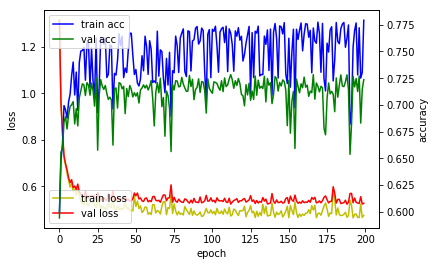

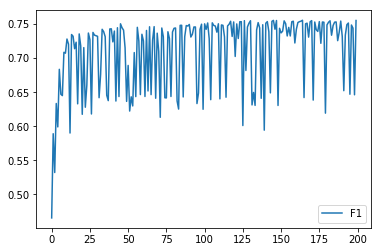

2 cross-validation
Training time: 1083.7452
Accuracy: 73.9051
AUROC: 0.8143
TPR: 0.7476538060479666
TNR: 0.7304483837330553
PRE: 0.735007688364941
F1: 0.7412768157146549
['72.8363', '73.9051']
['0.7505', '0.7413']


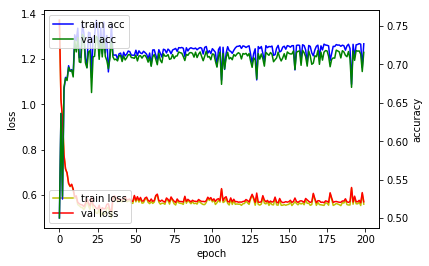

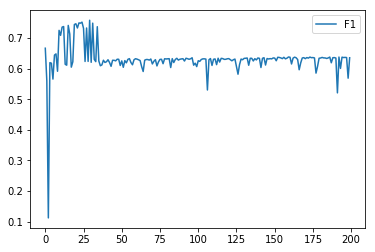

3 cross-validation


KeyboardInterrupt: 

In [29]:
acc_list,auroc_list,TPR_list,TNR_list,PRE_list,F1_list=[],[],[],[],[],[]
if opt_semi=='on':
    repmat_pos=np.tile(np.array([0,1]),(top_pos,1))
    repmat_neg=np.tile(np.array([1,0]),(top_neg,1))
print('MODEL: '+name_model[:2])
print('Semi-supervised mode: '+opt_semi)
print('N_label: '+ N_label)
if opt_semi=='on':
    if name_model[:2]=='m2':
        unlabel_data=M1.predict(load_unlabel(config,unlabel_file))
    elif name_model[:2]=='m1':
        unlabel_data=load_unlabel(config,unlabel_file)
    unlabel_len=len(unlabel_data)
    u_index = np.arange(unlabel_len)
for neg in neg_file_list: 
    print('-----------------------------------------------')   
    config.Dataset['neg_filename']='neg_sample_'+neg+'.txt'
    print(config.Dataset['neg_filename'])
    load_pos_neg_samples(config,DTI,verbose=0)

    rand_ind=np.arange(9592)
    np.random.shuffle(rand_ind)
    for order_CV in range(1,5):        
        print(str(order_CV)+' cross-validation')
        train_x,train_y,test_x,test_y=load_train_test_5fold_CV(config,DTI,rand_ind,order_CV)

        if name_model[:2]=='m2':
            label_train_x,label_train_y = load_label_train_test(train_x,train_y,N_label=N_label,stacked_model=M1)
            label_test_x=M1.predict(test_x)
            label_test_y=test_y
        elif name_model[:2]=='m1':
            label_train_x,label_train_y = load_label_train_test(train_x,train_y,N_label=N_label,
                                                                stacked_model=None)
            label_test_x=test_x
            label_test_y=test_y

        input_dim=int(np.shape(label_train_x)[1])

        reg=regularizers.l2(0.001)
        classifier_layers = [
            create_dense_layers(stage='classifier_1', units=1000, 
                                activation='relu', dropout=0.3,kernel_regularizer=reg),
            create_dense_layers(stage='classifier_2', units=512, 
                                activation='relu', dropout=0.3,kernel_regularizer=reg),
            create_dense_layers(stage='classifier_3', units=150, 
                                activation='relu', dropout=0.3,kernel_regularizer=reg),
            Dense(2, name='classifier_end'),
            Activation('softmax', name='y_predicted')
        ]

        x_in =Input(shape=(input_dim,), name='x_Input')
        y_output=inst_layers(classifier_layers,x_in)
        optimizer_l = Adam(lr=label_lr)

        classifier=Model(x_in,y_output)
        classifier.compile(optimizer=optimizer_l,
                    loss={'y_predicted':'categorical_crossentropy'},
                    metrics=['accuracy'])

        history_train = []
        history_test = []
        history_test_F1=[]

        checkpoint_cls=0.1
        semi_train_x=label_train_x
        semi_train_y=label_train_y
        if opt_semi=='on':
            semi_unlabel=unlabel_data
        start=time.time()
        for epoch in range(epochs):
            index = np.arange(len(semi_train_x))
            np.random.shuffle(index)
            batches = len(semi_train_x) // batch_size

            for i in range(batches):
                index_range =  index[i * batch_size:(i+1) * batch_size]
                loss = classifier.train_on_batch(
                    x=[semi_train_x[index_range]],
                    y={'y_predicted': semi_train_y[index_range]})
            l = classifier.evaluate(
                x=[semi_train_x],
                y={'y_predicted': semi_train_y},
                verbose=opt_verbose_training)
            l_test = classifier.evaluate(
                x=[label_test_x],
                y={'y_predicted': label_test_y},
                verbose=opt_verbose_training)
            l_test_F1=[float(get_metrics_values(classifier, label_test_x, label_test_y,verbose=0)[6])]

            if opt_semi=='on' and epoch>=thr_epoch:
                semi_train_x,semi_train_y,semi_unlabel,u_index=loop_self_training(
                                                                            classifier,
                                                                            label_train_x,label_train_y,
                                                                            semi_unlabel,u_index, u_N,
                                                                            top_pos,top_neg,
                                                                            repmat_pos,repmat_neg)
            
            if opt_save_model=='on' and l_test[opt_acc_loc]>checkpoint_cls:
                checkpoint_cls=l_test[opt_acc_loc]
#                 s=l_model_filename+'_acc_'+str(round(l_test[opt_acc_loc],4))+'_F1_'+str(round(l_test_F1[0],4))
                classifier.save(l_model_filename+'.h5')
#                 classifier.save(s+'.h5')
            history_train.append(l) 
            history_test.append(l_test)
            history_test_F1.append(l_test_F1)
        end=time.time()
        print('Training time: %.4f' %(end-start))
        if opt_save_model=='on':
            classifier.load_weights(l_model_filename+'.h5')
#             classifier.load_weights(s+'.h5')

        y_pred,accuracy,auroc,TPR,TNR,PRE,F1=get_metrics_values(classifier, label_test_x, label_test_y,
                                                                verbose=1)
        auroc_list.append(auroc)
        TPR_list.append(TPR)
        TNR_list.append(TNR)
        PRE_list.append(PRE)
        acc_list.append(accuracy)
        F1_list.append(F1)
#         acc_list.append(np.average(np.transpose(history_test)[1][-5:]))
#         F1_list.append(np.average(history_test_F1[-5:]))
        print(acc_list)
        print(F1_list)
        #     plot_roc_curve(classifier,label_test_x,label_test_y)
        plot_epoch_acc_loss(np.concatenate((history_train,history_test),axis=1),validation='on')
        plot_epoch(history_test_F1,loc=0,label='F1')
        #     plot_epoch(history_test,loss_loc=opt_loss_loc,label='test_loss')
        #   plot_epoch_loss_w_test(history_train,history_test) 
print(label_train_x.shape)
print(semi_train_x.shape)
with open(l_model_filename+'.txt','w') as f:
    acc=[float(v) for v in acc_list]
    auroc=[float(v) for v in auroc_list]
    f1=[float(v) for v in F1_list]
#     acc_list=[str(v) for v in acc]
#     F1_list=[str(v) for v in f1]
    f.write('Avg acc:\n' + str(np.average(acc)))
    f.write('\nStd acc:\n' + str(np.std(acc)))
    f.write('\nAvg auroc:\n' + str(np.average(auroc)))
    f.write('\nStd auroc:\n' + str(np.std(auroc)))
    f.write('\nAvg F1:\n' + str(np.average(f1)))
    f.write('\nStd F1:\n' + str(np.std(f1)))
    f.write('\nacc\n'+'\n'.join(acc_list))
    f.write('\nauroc\n'+'\n'.join(auroc_list))
    f.write('\nTPR\n'+'\n'.join(TPR_list))
    f.write('\nTNR\n'+'\n'.join(TNR_list))
    f.write('\nPRE\n'+'\n'.join(PRE_list))
    f.write('\nF1\n'+'\n'.join(F1_list))
print('--------------------finish---------------------------')    

In [ ]:
print('----------------')

In [21]:
with open(l_model_filename+'.txt','w') as f:
    acc=[float(v) for v in acc_list]
    auroc=[float(v) for v in auroc_list]
    f1=[float(v) for v in F1_list]
#     acc_list=[str(v) for v in acc]
#     F1_list=[str(v) for v in f1]
    f.write('Avg acc:\n' + str(np.average(acc)))
    f.write('\nStd acc:\n' + str(np.std(acc)))
    f.write('\nAvg auroc:\n' + str(np.average(auroc)))
    f.write('\nStd auroc:\n' + str(np.std(auroc)))
    f.write('\nAvg F1:\n' + str(np.average(f1)))
    f.write('\nStd F1:\n' + str(np.std(f1)))
    f.write('\nacc\n'+'\n'.join(acc_list))
    f.write('\nauroc\n'+'\n'.join(auroc_list))
    f.write('\nTPR\n'+'\n'.join(TPR_list))
    f.write('\nTNR\n'+'\n'.join(TNR_list))
    f.write('\nPRE\n'+'\n'.join(PRE_list))
    f.write('\nF1\n'+'\n'.join(F1_list))
print('--------------------finish---------------------------')    

--------------------finish---------------------------


In [11]:
classifier=keras.models.load_model(checkpoint_path+'/tot_m1_semi_50_1000_20190529.h5')


In [47]:
neg='9'
config.Dataset['neg_filename']='neg_sample_'+neg+'.txt'
print(config.Dataset['neg_filename'])
load_pos_neg_samples(config,DTI,verbose=0)

rand_ind=np.arange(9592)
np.random.shuffle(rand_ind)
train_x,train_y,test_x,test_y=load_train_test_5fold_CV(config,DTI,rand_ind,1)
label_train_x,label_train_y = load_label_train_test(train_x,train_y,N_label=N_label,
                                                                stacked_model=None)
label_test_x=test_x
label_test_y=test_y
get_auroc(model=classifier,test_x=label_test_x,test_y=label_test_y)

neg_sample_9.txt
Load existing positive & negative sample files.


0.8457720666187516

In [50]:

y_test=[]
for v in label_test_y:
    y_test.append(list(v).index(1))
y_pred = classifier.predict(label_test_x)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred, pos_label=1)
with open('./model/model_checkpoints/g_m1_semi_tpr.txt','w') as f:
    kk=[str(v) for v in list(tpr)]
    f.write('\t'.join(list(kk)))
roc_auc = auc(fpr, tpr)